# Precipitation

- Summary of precipitation projections over the Arctic ocean & sea-ice in UKESM1 SSP585
- Includes breakdown of snowfall vs rainfall
- Uses variables `pr`, `prsn` which have been regridded from lat-lon to UKESM1-0-LL ocean grid
- Uses `NSIDC_Regions_Masks_LatLon_nearest_s2d.nc` which can be generated in `regrid.ipynb`
- Base units: kg m-2 s-1 (= mm s-1)

## Imports & defaults

In [1]:
import libs.analysis
import libs.plot
import libs.utils
import libs.vars
import matplotlib
import numpy as np
import xarray

matplotlib.rcParams.update({ 'font.size': 18 })

import warnings
warnings.filterwarnings('ignore')

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
path_nsidc_mask = '_data/_cache/NSIDC_Regions_Masks_Ocean_nearest_s2d.nc'
nsidc_mask = xarray.open_mfdataset(paths=path_nsidc_mask, combine='by_coords').mask
# base units = kg m-2 s-1
units_daily = 'mm day⁻¹'

areacello = libs.utils.get_data('Ofx', 'piControl', 'UKESM1-0-LL', 'areacello', 'r1i1p1f2').areacello
areacello_w = areacello.fillna(0)

nsidc_all = [
    r for r in libs.vars.nsidc_regions() if r['label'] == 'All'
][0]

pr_base = libs.utils.get_data('Amon', 'ssp585', 'UKESM1-0-LL', 'pr', 'r2i1p1f2')
pr = pr_base.pr\
    .where(pr_base.pr.latitude > 60)\
    .where(np.isin(nsidc_mask.values, nsidc_all['values'])) * 86400

prsn_base = libs.utils.get_data('Amon', 'ssp585', 'UKESM1-0-LL', 'prsn', 'r2i1p1f2')
prsn = prsn_base.prsn\
    .where(prsn_base.prsn.latitude > 60)\
    .where(np.isin(nsidc_mask.values, nsidc_all['values'])) * 86400

prra = pr - prsn
pr_arr = [
    {
        'color': None,
        'data': pr,
        'label': 'Precipitation'
    },
    {
        'color': None,
        'data': prsn,
        'label': 'Snowfall'
    },
    {
        'color': None,
        'data': prra,
        'label': 'Rainfall'
    },
]

pr_arr_weighted_mean = []
for item in pr_arr:
    pr_weighted = item['data'].weighted(areacello_w)
    pr_weighted_mean = pr_weighted.mean(dim=pr_weighted.weights.dims, skipna=True)

    pr_arr_weighted_mean.append({
        'color': item['color'],
        'data': pr_weighted_mean,
        'label': item['label']
    })


colormesh_kwargs = {
    'extend': 'max',
    'levels': 21,
    #'shading': 'flat',
    'vmin': 0,
    'vmax': 3,
    'x': 'longitude',
    'y': 'latitude'
}
time_title = '{time} SSP585 mean daily {label} over ocean & sea ice 60-90°N ({units})'
time_series_ylabel = f'precipitation ({units_daily})'
ensemble_time_slices = libs.analysis.generate_slices(pr_arr)

## Time series

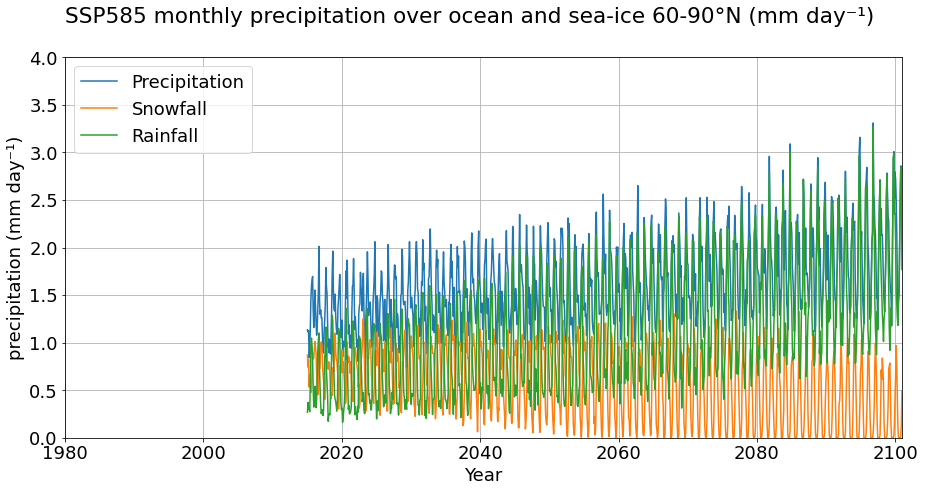

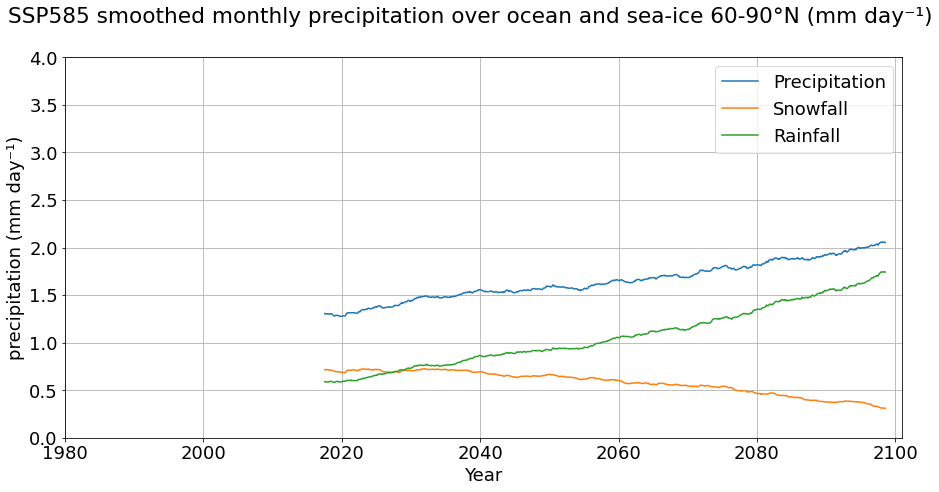

In [10]:
libs.plot.time_series(
    pr_arr_weighted_mean,
    title=f'SSP585 monthly precipitation over ocean and sea-ice 60-90°N ({units_daily})',
    xattr='time',
    ylabel=time_series_ylabel,
    yrange=[0, 4],
    process=lambda x: x.fillna(0)
)

libs.plot.time_series(
    pr_arr_weighted_mean,
    title=f'SSP585 smoothed monthly precipitation over ocean and sea-ice 60-90°N ({units_daily})',
    xattr='time',
    ylabel=time_series_ylabel,
    yrange=[0, 4],
    process=lambda x: libs.analysis.smoothed_mean(x.fillna(0))
)

### Precipitation over sea-ice extent

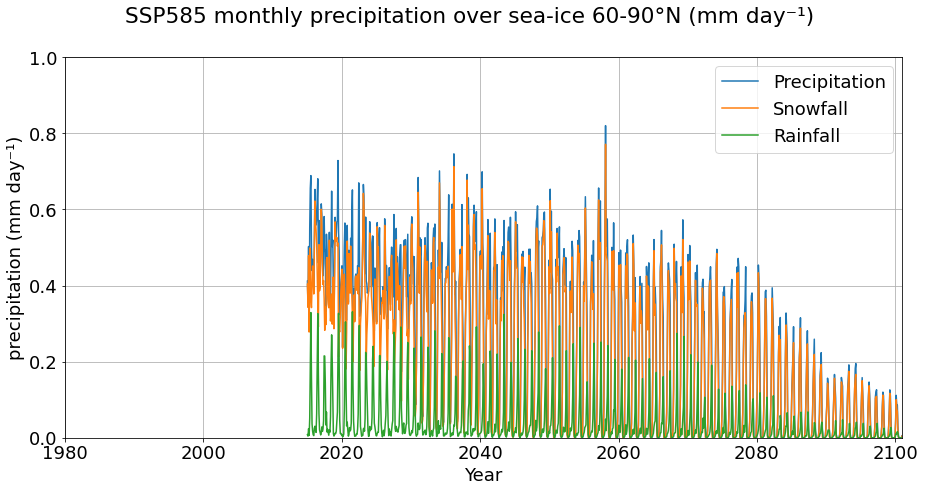

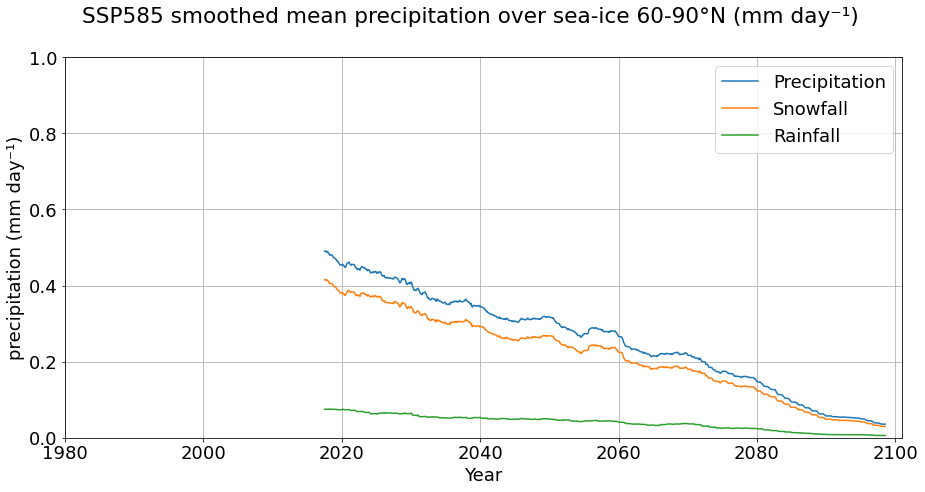

In [18]:
siconc_base = libs.utils.get_data('SImon', 'ssp585', 'UKESM1-0-LL', 'siconc', 'r2i1p1f2')
siconc = siconc_base.siconc
siconc = siconc.where(siconc.latitude > 60).where(np.isin(nsidc_mask.values, nsidc_all['values']))

pr_siconc_arr = []
for item in pr_arr:
    item_weighted = (item['data'] * siconc / 100).weighted(areacello_w)
    item_weighted_mean = item_weighted.mean(dim=item_weighted.weights.dims, skipna=True)
    pr_siconc_arr.append({
        'color': item['color'],
        'data': item_weighted_mean,
        'label': item['label']
    })

libs.plot.time_series(
    pr_siconc_arr,
    title=f'SSP585 monthly precipitation over sea-ice 60-90°N ({units_daily})',
    xattr='time',
    ylabel=f'precipitation ({units_daily})',
    yrange=[0, 1]
)

libs.plot.time_series(
    pr_siconc_arr,
    title=f'SSP585 smoothed mean precipitation over sea-ice 60-90°N ({units_daily})',
    xattr='time',
    ylabel=f'precipitation ({units_daily})',
    yrange=[0, 1],
    process=lambda x: libs.analysis.smoothed_mean(x)
)

## Monthly variability (time)

### Full region

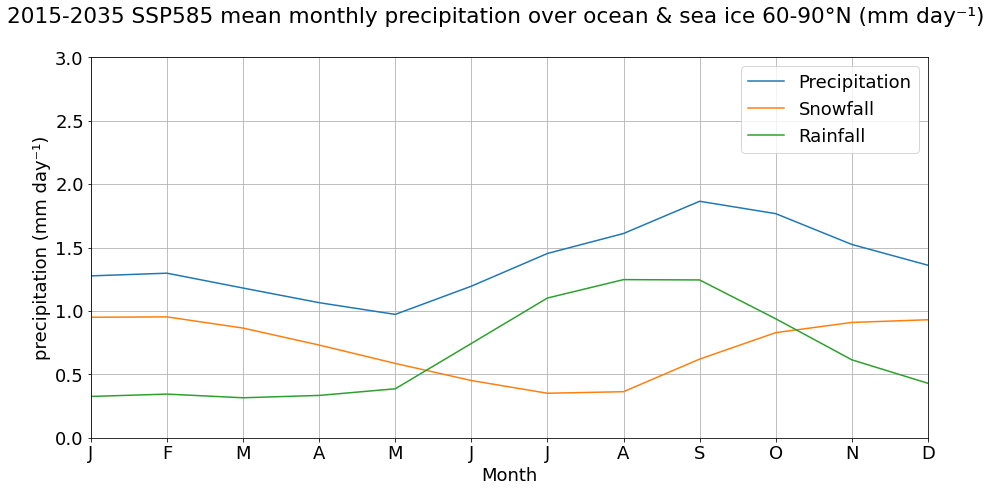

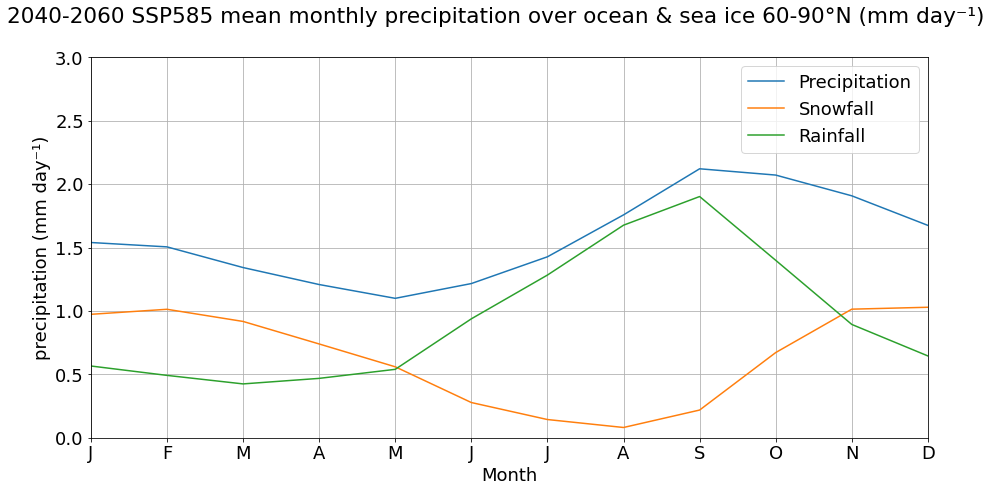

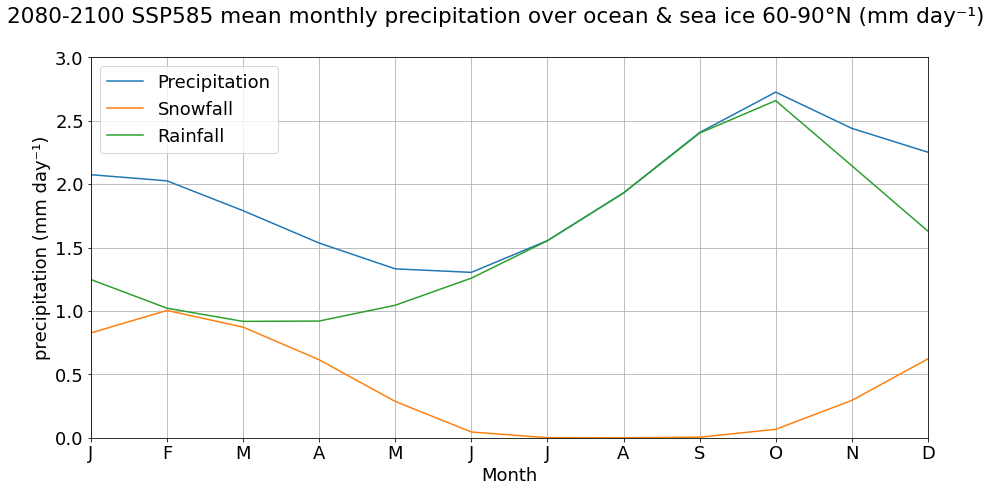

In [15]:
for s in ensemble_time_slices:
    ensemble_processed = [{ 
        'color': item['color'],
        'data': libs.analysis.monthly_weighted(
            item['data'],
            areacello_w,
            method='mean'
        ),
        'label': item['label']
    } for item in s['ensemble']]
    
    s_label = s['label']

    libs.plot.monthly_variability(
        ensemble_processed,
        title=f'{s_label} SSP585 mean monthly precipitation over ocean & sea ice 60-90°N ({units_daily})',
        ylabel=f'precipitation ({units_daily})',
        yrange=(0, 3)
    )

### Sea-ice region

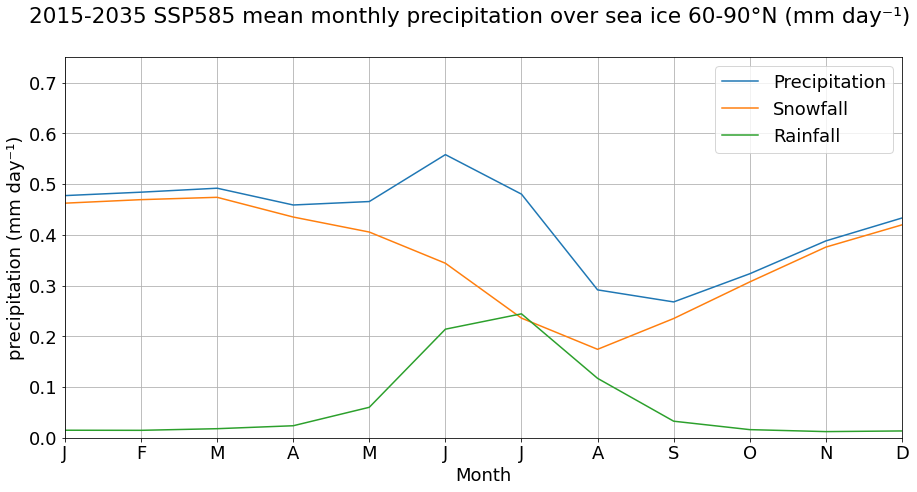

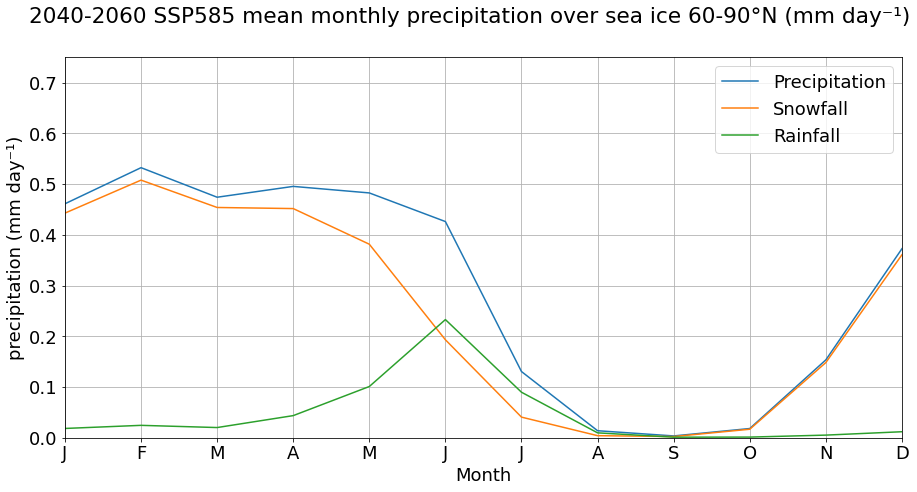

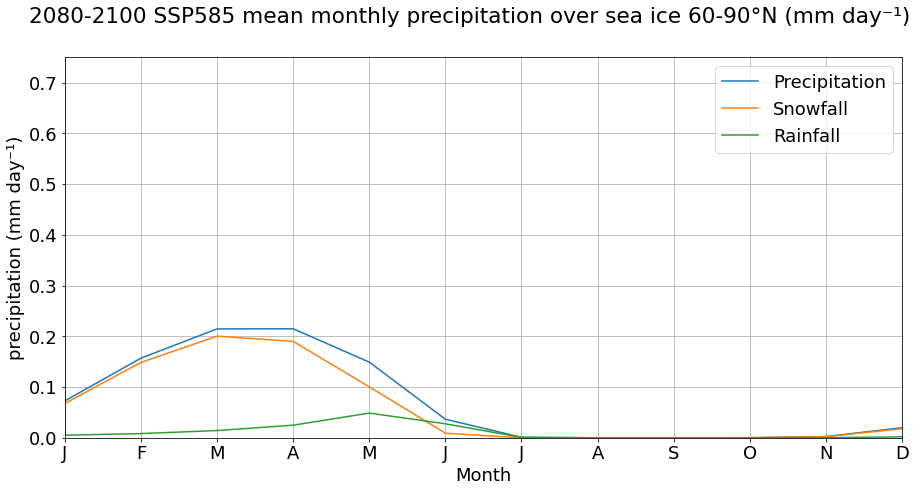

In [19]:
ensemble_si_time_slices = libs.analysis.generate_slices(pr_siconc_arr)

for s in ensemble_si_time_slices:
    ensemble_processed = [{ 
        'color': item['color'],
        'data': libs.analysis.monthly_weighted(
            item['data'],
            areacello_w,
            method='mean'
        ),
        'label': item['label']
    } for item in s['ensemble']]
    
    s_label = s['label']

    libs.plot.monthly_variability(
        ensemble_processed,
        title=f'{s_label} SSP585 mean monthly precipitation over sea ice 60-90°N ({units_daily})',
        ylabel=f'precipitation ({units_daily})',
        yrange=(0, 0.75)
    )

### Regional precipitation

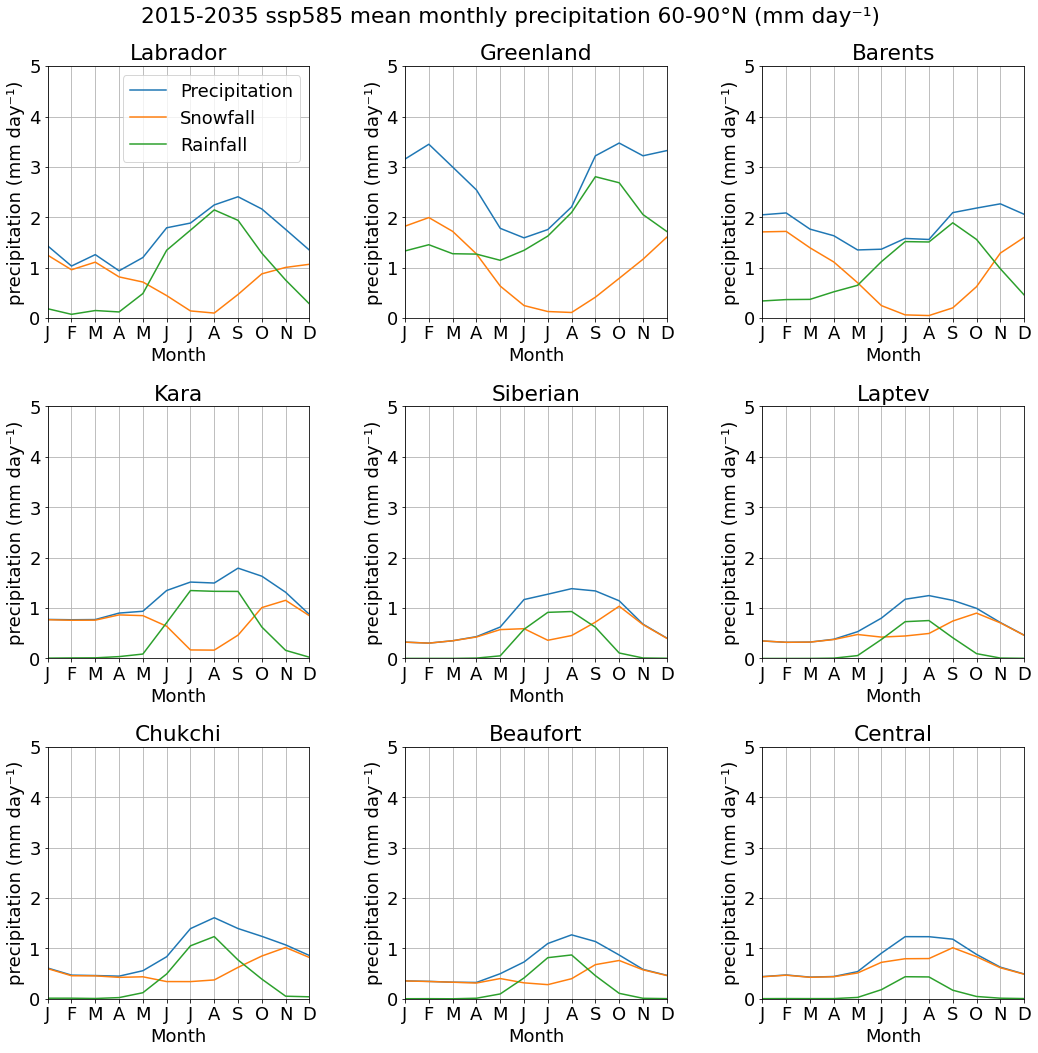

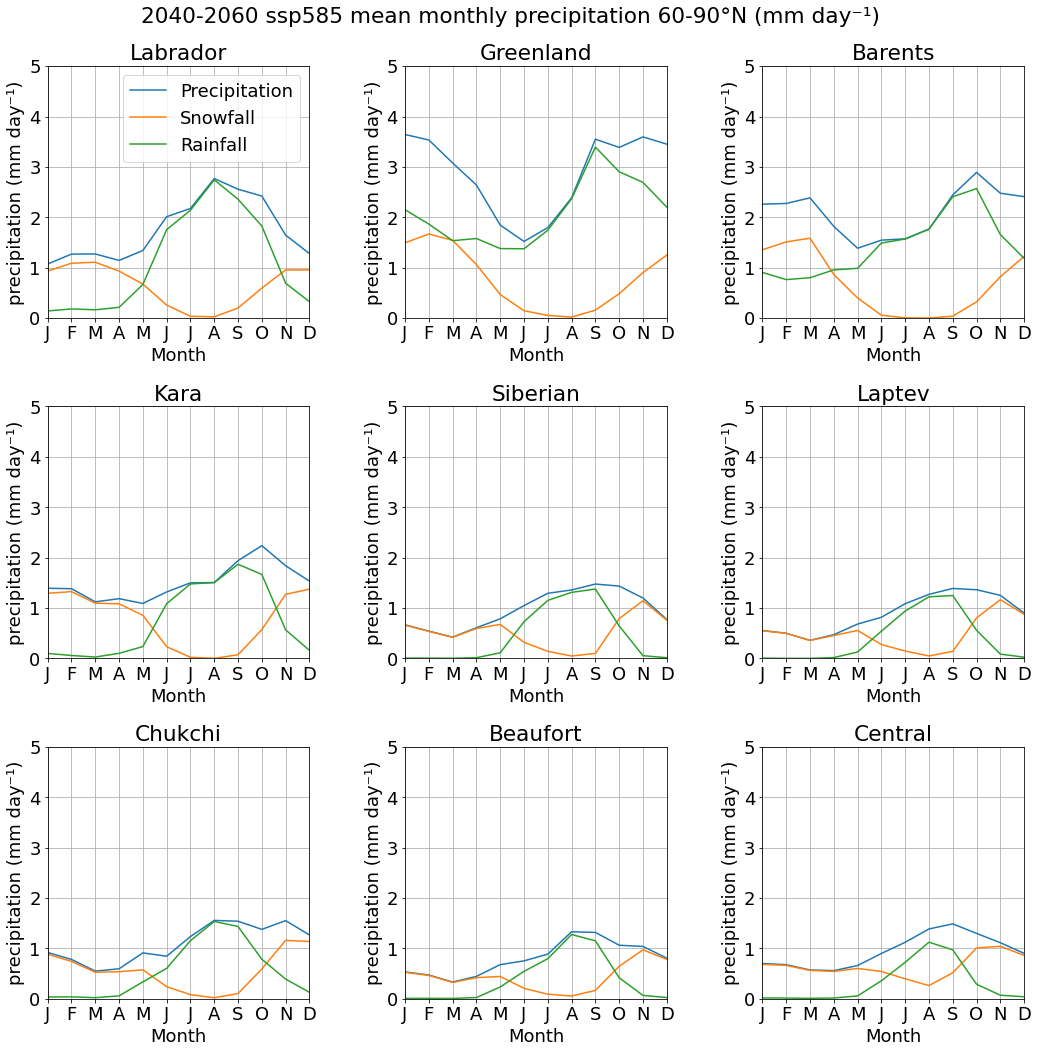

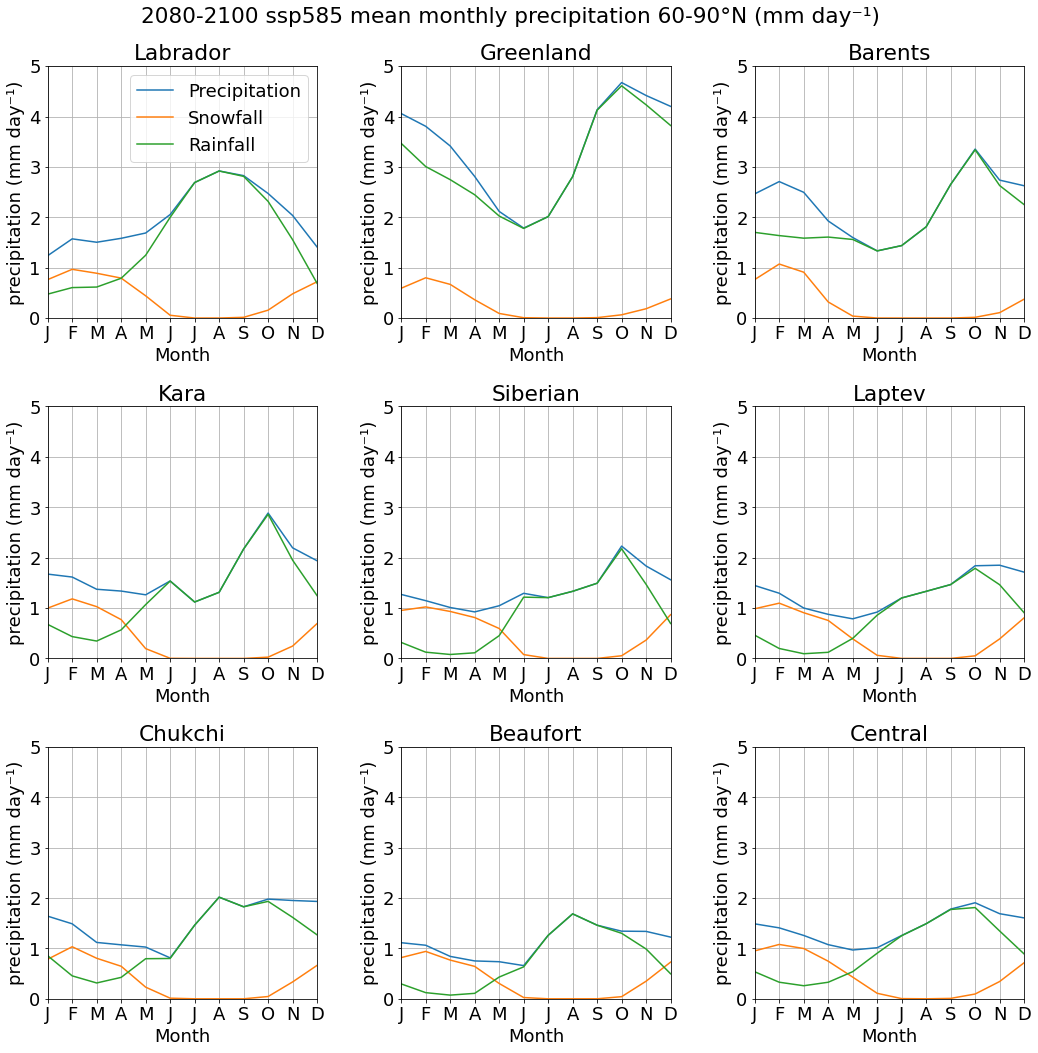

In [21]:
for s in ensemble_time_slices:
    s_label = s['label']

    libs.plot.monthly_variability_regional(
        s['ensemble'], 
        title=f'{s_label} ssp585 mean monthly precipitation 60-90°N ({units_daily})',
        ylabel=f'precipitation ({units_daily})',
        mask_type='ocean',
        calc_ensemble_mean=False,
        process=lambda x: libs.analysis.monthly_weighted(
            x,
            areacello_w,
            method='mean'
        ),
        ylim=(0, 5)
    )

## Seasonal variability (spatial)

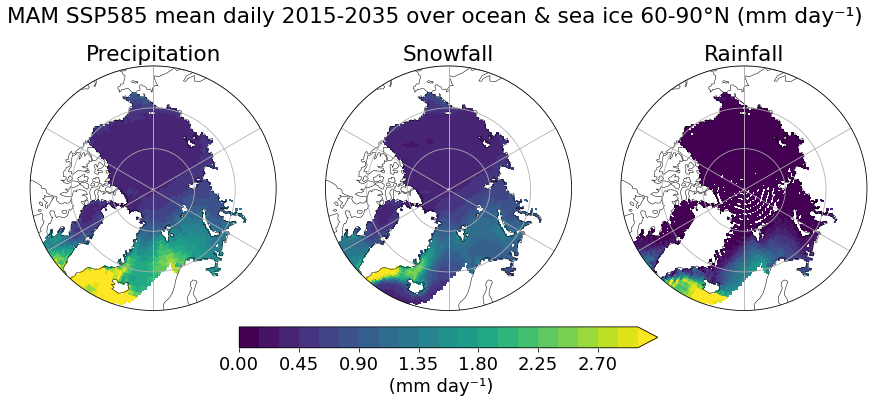

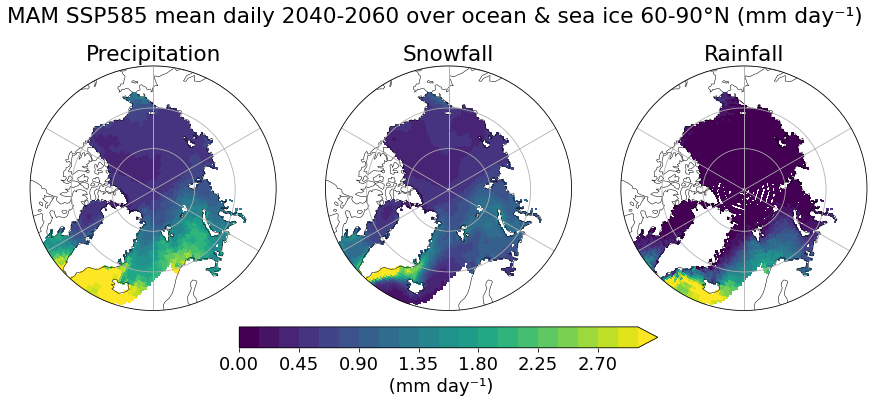

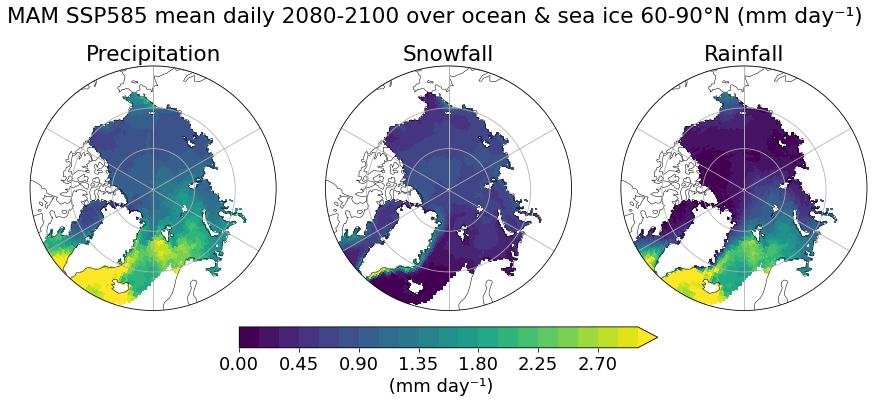

In [3]:
libs.plot.calendar_division_spatial(
    ensemble_time_slices, 
    colormesh_kwargs=colormesh_kwargs,
    division='season',
    time='MAM',
    title=time_title,
    units=units_daily
)

### MAM

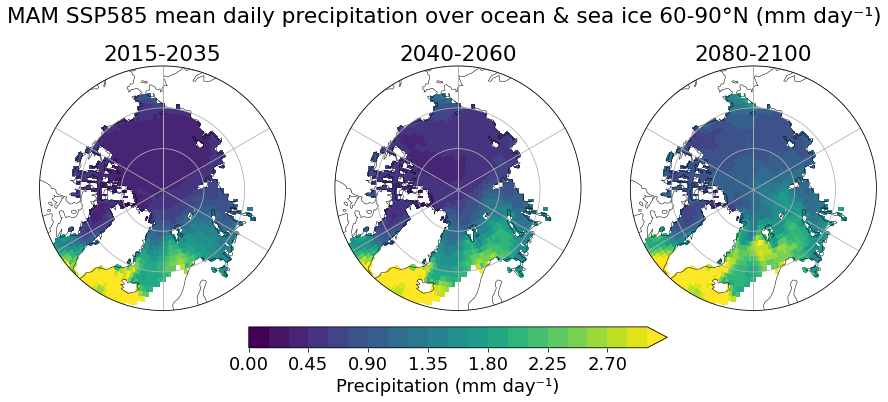

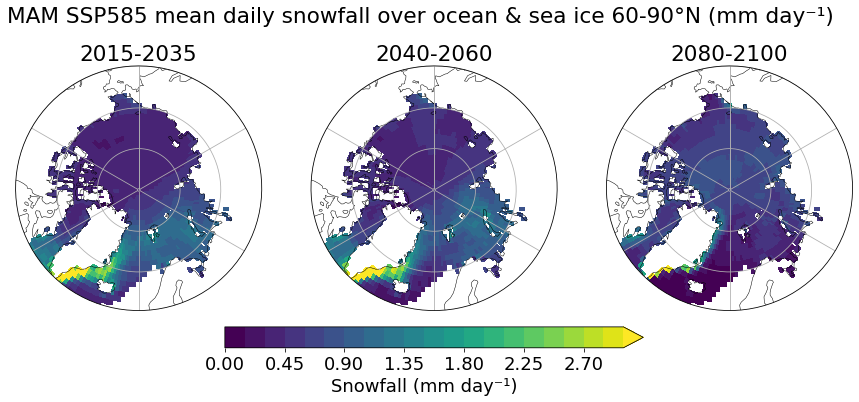

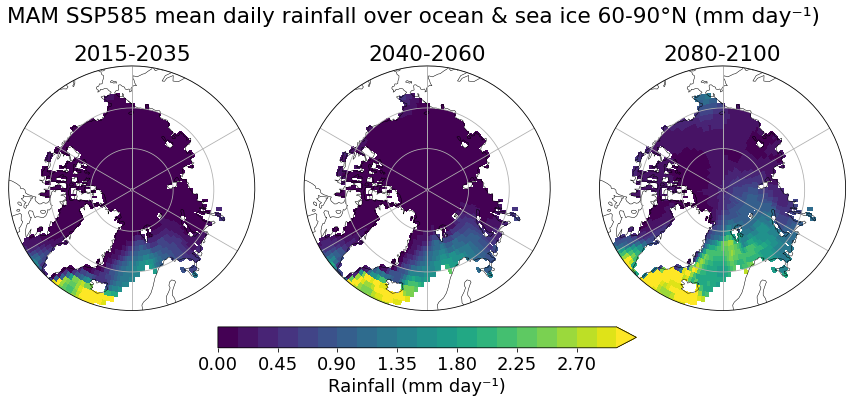

In [11]:
libs.plot.seasonal_spatial(
    pr_arr, 
    colormesh_kwargs=colormesh_kwargs,
    seasons=['MAM'],
    title=seasonal_spatial_title,
    units=units_daily
)

### JJA

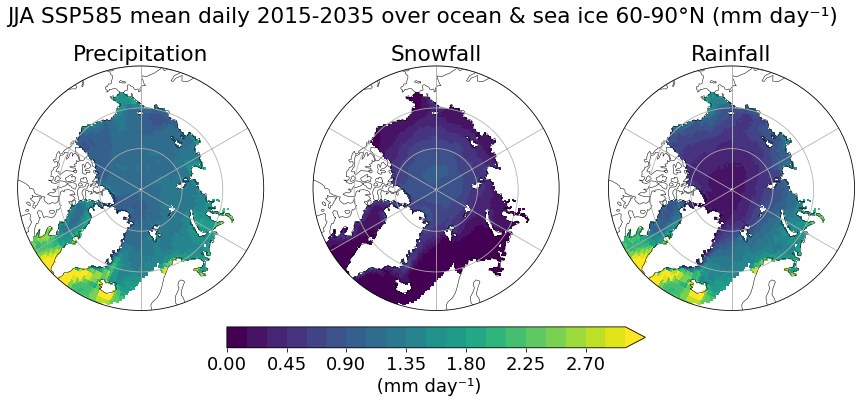

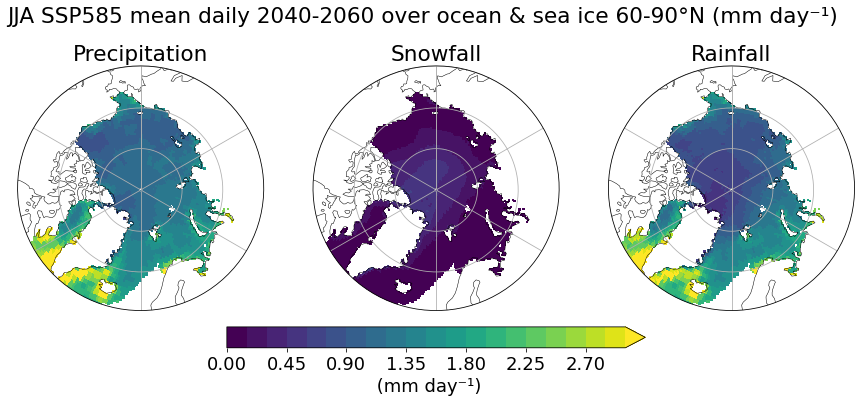

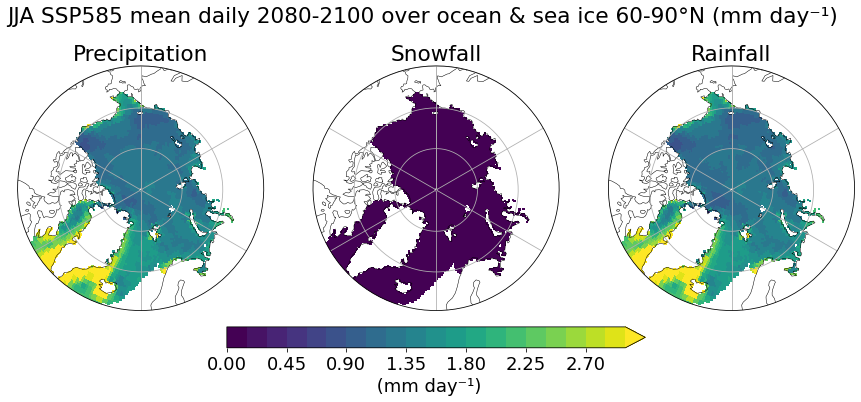

In [4]:
libs.plot.calendar_division_spatial(
    ensemble_time_slices, 
    colormesh_kwargs=colormesh_kwargs,
    division='season',
    time='JJA',
    title=time_title,
    units=units_daily
)

### SON

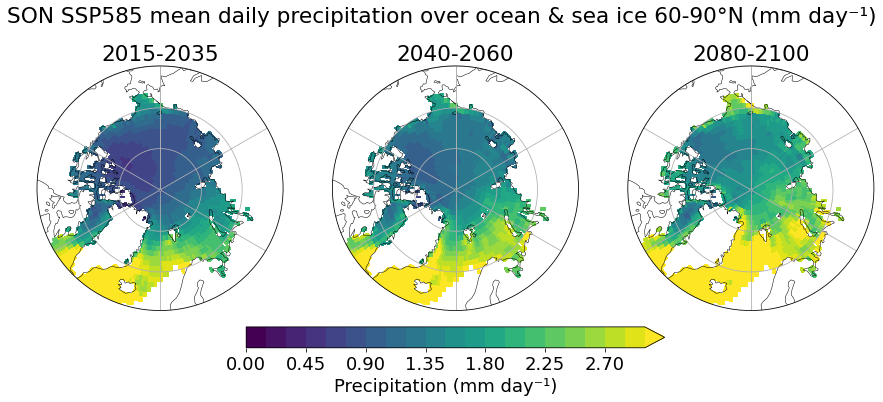

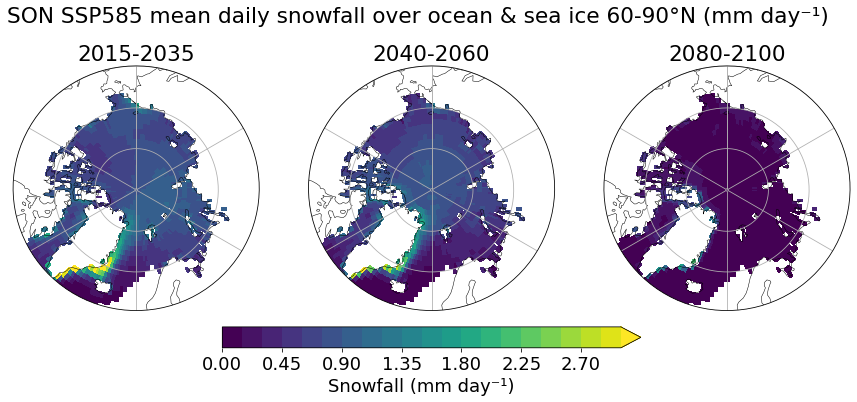

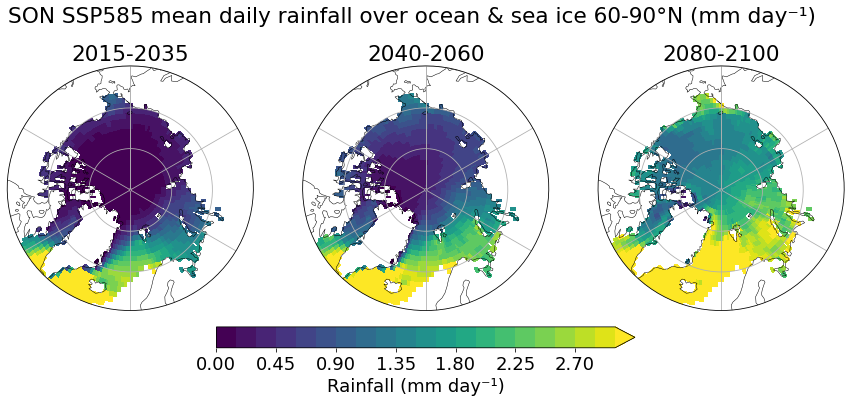

In [13]:
libs.plot.seasonal_spatial(
    pr_arr, 
    colormesh_kwargs=colormesh_kwargs,
    seasons=['SON'],
    title=seasonal_spatial_title,
    units=units_daily
)

### DJF

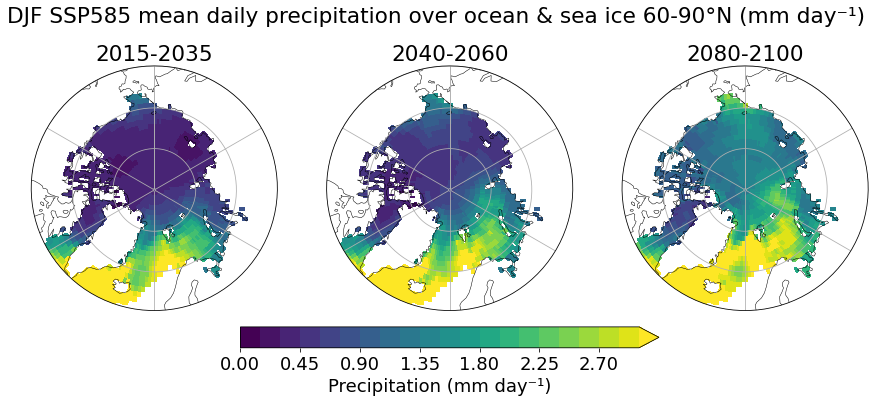

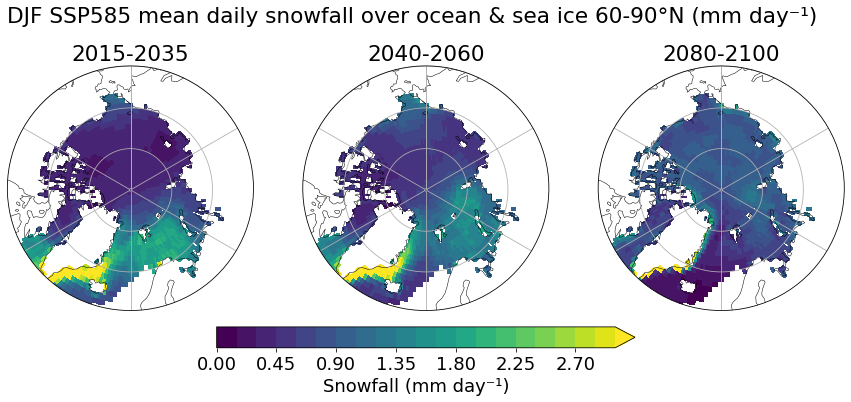

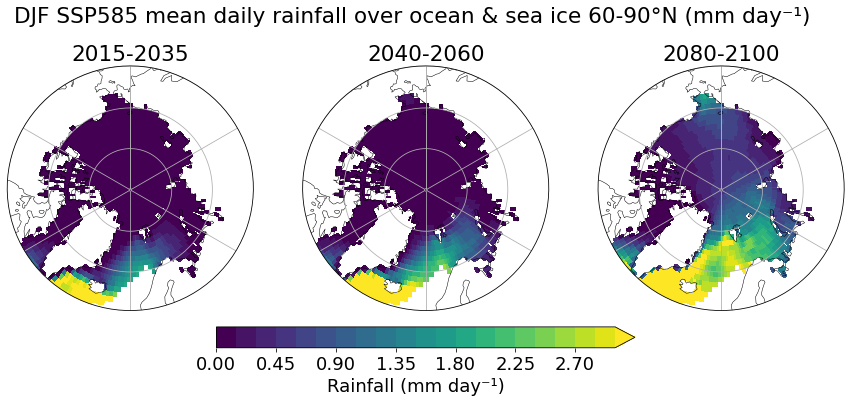

In [14]:
libs.plot.seasonal_spatial(
    pr_arr, 
    colormesh_kwargs=colormesh_kwargs,
    seasons=['DJF'],
    title=seasonal_spatial_title,
    units=units_daily
)